# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

Set a batch size of 64.

In [2]:
bs=64

Untar the data at `URLs.PETS`, and set the variable `path` to the returned path with `images` appended to the end.

In [3]:
path = untar_data(URLs.PETS)

## Data augmentation

Create a variable `tfms` that captures the output of the `get_transforms` function, with the following arguments:
- max_rotate=20
- max_zoom=1.3
- max_lighting=0.4
- max_warp=0.4
- p_affine=1.
- p_lighting=1.

In [4]:
tfms = get_transforms(
    max_rotate=20,
    max_zoom=1.3,
    max_lighting=0.4,
    max_warp=0.4,
    p_affine=1.,
    p_lighting=1.
)

Explain what each of these are.

- max_rotate is the maximum number of degrees to rotate the image in either direction
- max_zoom is the maximum amount to zoom into the image
- max_lighting is "a random lighting and contrast change"
- max_warp is a random symmetric warp
- p_affine is the probability that each affine transform or symmetric warp is applied
- p_lighting is the probability that each lighting transform is applied

Create an `ImageList` from the folder `path` split by a random 20% (using a random seed of 2). Assign it to the variable `src`. What kind of object does this return? Can you find (in code) why this is the case?

In [5]:
src = (ImageList.from_folder(path)
       .split_by_rand_pct(seed=2))

It returns an `ItemLists` object, which is an object representing a pair of datasets, `train` and `valid` (and optionally a `test`.

Write a function `get_data` that takes `src` and labels it using the regex `([^/]+)_\d+.jpg$`, transforms it with `tfms`, takes `size` as an argument, takes `padding_mode` as an argument that defaults to `reflection`, creates a databunch with batch size `bs`, and normalizes using the imagenet stats. What type would you expect this to return?

In [14]:
def get_data(size, bs, padding_mode='reflection'):
    return (src
            .label_from_re(r'([^/]+)_\d+.(jpg|png)$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

I expect this to return an `ImageDataBunch`.

Create a variable `data` that calls `get_data` with size 224, `bs=bs`, and padding type `zeros`.

In [15]:
data = get_data(224, bs, 'zeros')

Write a function `_plot` that plots the fourth image in the training dataset. Pass it to `plot_multi` to create a 3x3 grid of augmented images.

In [25]:
def _plot(i, j, ax):
    x,y = data.train_ds[3]
    x.show(ax=ax, y=y)

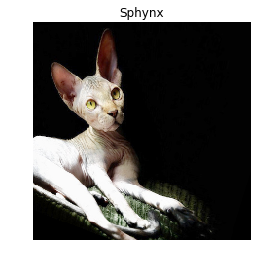

In [29]:
fig, ax = plt.subplots()
_plot(1,2,ax)

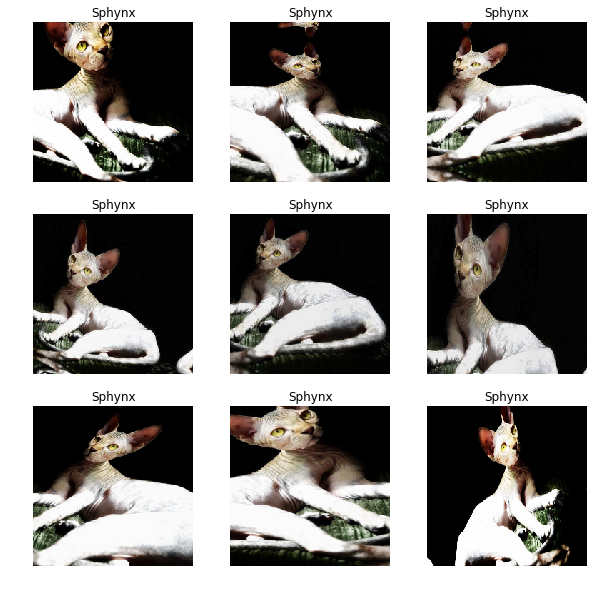

In [33]:
plot_multi(_plot, 3, 3, (10,10))

Create a new variable `data` with size 224 and the same bs.

In [30]:
data = get_data(224, bs)

Use the same process to plot a 3x3 grid of 8x8 images of augmented data. This time allow the default padding mode.

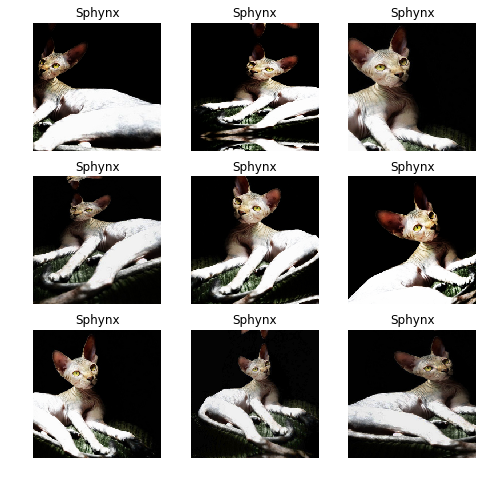

In [34]:
plot_multi(_plot, 3, 3, (8,8))

## Train a model

Call `gc.collect`. Can you explain what this does?

In [35]:
gc.collect()

57236

This reclaims some GPU memory by deleting inaccessible objects.

Create a `cnn_learner` named `learn` with data `data`, architecture resnet34, using the `error_rate` metric, and `bn_final` set to true.

In [39]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate], bn_final=True)

Fit a cycle with 3 epochs, a slice up to 1e-2, with `pct_start=0.8`. Can you explain what `pct_start` does?

In [40]:
learn.fit_one_cycle(3, max_lr=1e-2, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.878907,2.285611,0.588972,01:26
1,2.347988,2.016891,0.544993,01:24
2,2.143809,1.607448,0.465156,01:24


Pct. start dictates how many examples go into the "first phase" of the `OneCycle` policy.

Unfreeze the neural net. Fit another cycle with two epochs under the slice (1e-6, 1e-3). Same pct_start.

In [41]:
learn.unfreeze()

In [42]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.018182,1.571342,0.460081,01:58
1,1.926031,1.498686,0.434709,01:58


Create a new `data` object with size 352.

In [43]:
data = get_data(size=352, bs=16)

Train for another cycle with 2 epochs, this time with a `max_lr` of `slice(1e-6, 1e-4)`.

In [44]:
learn.data = data

In [45]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.151721,1.498414,0.430650,05:04
1,2.171128,1.474094,0.420839,05:02


Save the model under the name `352`.

In [46]:
learn.save('352')

## Convolution kernel

Create another new `data` with size 352 and batch size 16.

In [47]:
data = get_data(size=352, bs=16)

Create a new learner `learn` with the same specs as earlier, and load the weights from `352` to it. 

In [48]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate], bn_final=True)

In [49]:
learn.load('352')

Learner(data=ImageDataBunch;

Train: LabelList (11824 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
pug,boxer,scottish_terrier,Sphynx,english_cocker_spaniel
Path: /home/paperspace/.fastai/data/oxford-iiit-pet;

Valid: LabelList (2956 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
Siamese,basset_hound,samoyed,Egyptian_Mau,Russian_Blue
Path: /home/paperspace/.fastai/data/oxford-iiit-pet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

Set the variable `idx=0`. Set the values returned at position `idx` within the valid_ds and to `x` and `y`.

In [52]:
idx=1
x,y = data.valid_ds[idx]

Call the `show` method on x.

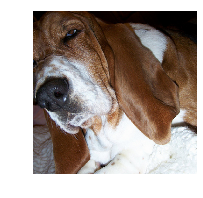

In [53]:
x.show()

Return the item at position `idx` in the `y` part of the `valid_ds`.

In [54]:
y

Category basset_hound

This is created for you, because it doesn't teach much. Maybe dig into the `expand` method.

In [58]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

Return the shape of `k`.

In [59]:
k.shape

torch.Size([1, 3, 3, 3])

Get the `x` value of the first item in `valid_ds`, get the `data` property and set it to `t`. What does the data property represent? 

In [67]:
t = x.data

Add a new dimension to `t` using the `None` index syntax.

In [68]:
t = t[None]

Create an image called `edge` by convolving `t` with our filter `k`.

In [69]:
edge = F.conv2d(t, k)

Run `show_image` over `edge`. Hint: you'll have to get the zeroth index of `edge` -- why?

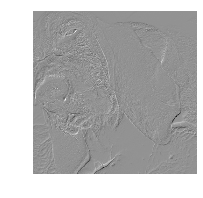

In [71]:
show_image(edge[0])

An extra dimension is added to account for the batch. You have to index into it to get an image of the appropriate shape.

Show the number of classes in `data`.

In [76]:
data.c

37

Print the model.

In [77]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Print a model summary.

In [79]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

## Heatmap

Get the model out of our learner and set it to `eval` mode.

In [80]:
model = learn.model.eval()

Get one item from the `x` data you created above. Call this `xb`. Hint: `one_item` returns a tuple, but we only need the first thing.

In [82]:
xb,_ = data.one_item(x)

Create an image from a denormed version of xb. Again, you'll have to index into this. Be sure you can explain why. Call the output `xb_im`.

In [85]:
xb_im = Image(data.denorm(xb)[0])

Put the `xb` variable on the GPU by calling `cuda()`.

In [86]:
xb = xb.cuda()

Import fastai.callbacks.hooks.

In [99]:
from fastai.callbacks.hooks import *

Create a function `hooked_backward` that returns two objects `grad_a` and `grad_g` representing the activations and the gradients. Make sure to use `with` statements here so that the hooks are removed after we get our results.

In [104]:
# model[0] represents the convolutional part
def hooked_backward(cat=y):
    with hook_output(model[0]) as hook_a:
        with hook_output(model[0], grad=True) as hook_g:
            preds = model(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

Create two objects, `hook_a` and `hook_g` with the outputs of `hooked_backward`.

In [105]:
hook_a, hook_g = hooked_backward()

Assign the stored activation outputs to a variable called `acts`. Make sure to call `.cpu` to put this back on the CPU.

In [108]:
acts = hook_a.stored.cpu()

Take an average over the channel dimension to get a 2d shape. Print out the shape.

In [111]:
acts.mean(1).shape, acts.shape

(torch.Size([1, 11, 11]), torch.Size([1, 512, 11, 11]))

In [112]:
avg_acts = acts.mean(1)

Write a function `show_heatmap` that does the following:
- takes an argument hm
- Creates a new matplotlib axis using `plt.subplots`
- shows `xb_im` on the new axis
- calls `ax.imshow` with arguments `alpha=0.6`, `extent=(0,352,352,0)`, `interpolation=bilinear`, `cmap=magma`. Look up what these mean.

In [123]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts[0], alpha=0.6, extent=(0,352,352,0), interpolation="bilinear", cmap="magma") 

Call `show_heatmap` on `avg_acts`.

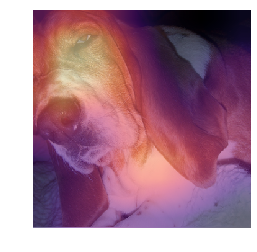

In [124]:
show_heatmap(avg_acts)

Alpha represents the transparency of the gradient visualization. Extent reflects two ranges represented as four coordinates: 
- The range from the top left pixel to the top right pixel (represented by the first two coordinates)
- The range from the bottom left pixel to the top left pixel (represented by the second two coordinates)
Interpolation dictates how matplotlib scales up the (smaller) image generated by the convolutional layers (in this case the output is a 11x11). Cmap represents the color mapping.

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

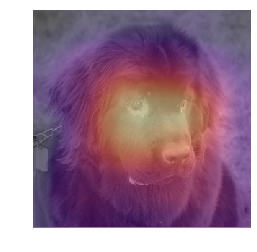

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

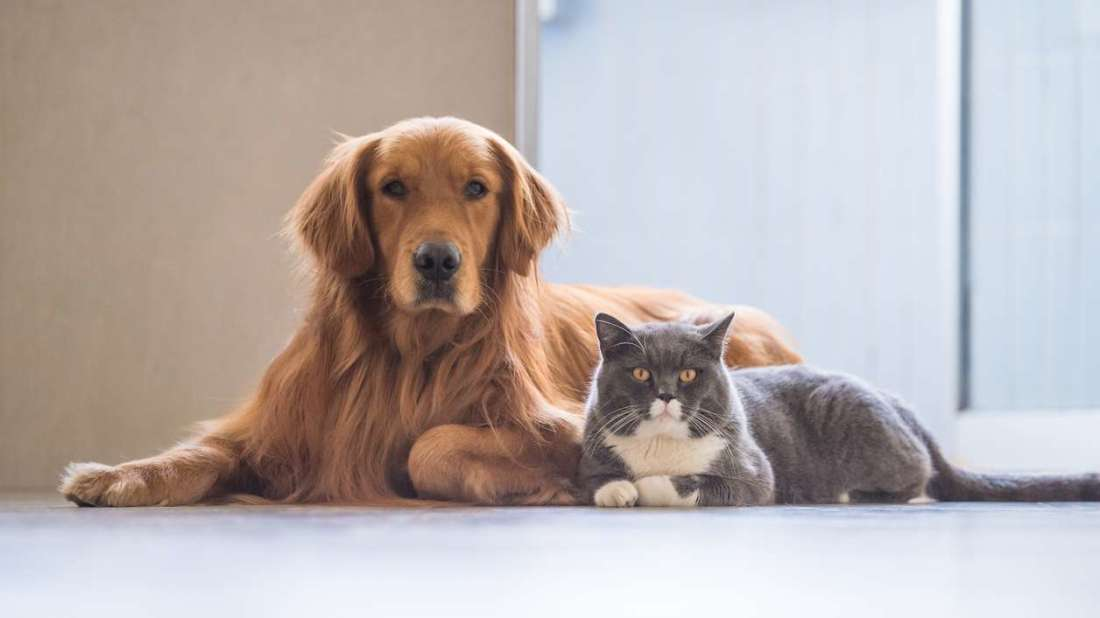

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

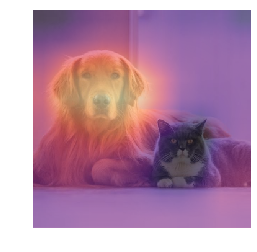

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'Abyssinian'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

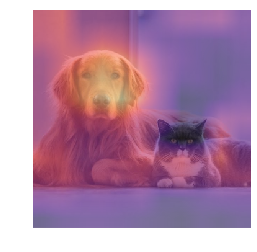

In [ ]:
show_heatmap(mult)

## fin